In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import cv2
import os
import keras
from keras import regularizers
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential


In [2]:
# Check if GPU is available
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3908670607955166297,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6932588160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1807861955195005365
 physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:2d:00.0, compute capability: 7.5"]

In [3]:
train_dir = './data/asl_alphabet_train'
test_dir = './data/asl_alphabet_test'

Labels: ['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


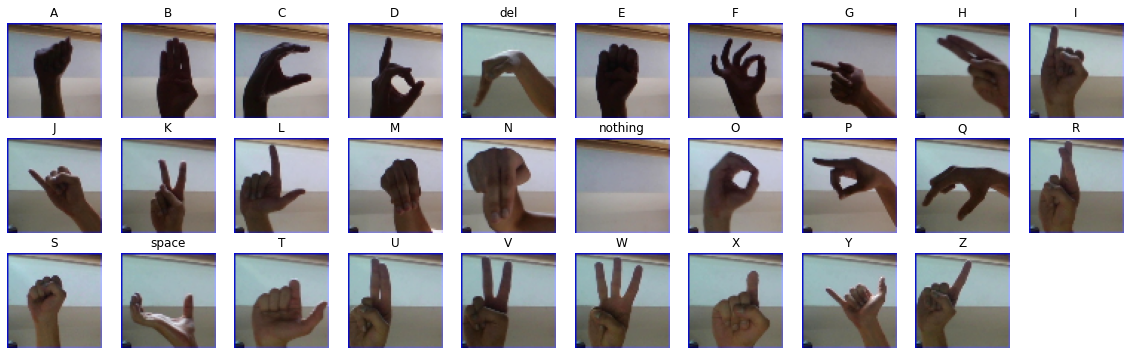

In [4]:
# store one image from each label for plotting
img_size = (64,64) 
imgs_plot_list = []
labels_plot_list = []
for folder in os.listdir(train_dir):
    for file in os.listdir(f'{train_dir}/{folder}'):
        filepath = f'{train_dir}/{folder}/{file}'
        image = cv2.imread(filepath)
        # resize image
        final_img = cv2.resize(image, img_size)
        # convert BGR to RGB color
        final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
        imgs_plot_list.append(final_img)
        labels_plot_list.append(folder)
        break

print(f'Labels: {labels_plot_list}')

# show one image from each class/label
figure = plt.figure(figsize = (20,6))
img_idx = 0
row = 3
col = 10
for i in range(1,(row*col)):
    figure.add_subplot(row, col, i)
    plt.axis('off')
    plt.imshow(imgs_plot_list[img_idx])
    plt.title(labels_plot_list[img_idx])
    img_idx = img_idx + 1
plt.show()

In [5]:
# dict for mapping an integer for each class/label
labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                   'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
                   'Z':25,'space':26,'del':27,'nothing':28}

def load_data():
    images_list = []
    labels_list = []
    size = (32,32)
    
    for folder in os.listdir(train_dir):
        for imgfile in os.listdir(f'{train_dir}/{folder}'):
            curr_img = cv2.imread(f'{train_dir}/{folder}/{imgfile}')
            # resize image
            curr_img = cv2.resize(curr_img, size)
            # store into images and labels lists
            images_list.append(curr_img)
            labels_list.append(labels_dict[folder])

    # make np array
    images_arr = np.array(images_list)
    # normalize values
    images_arr = images_arr.astype('float32')/255.0
    # one hot encode labels
    labels_arr = keras.utils.to_categorical(labels_list)
    # split into training and testing data
    x_train, x_test, y_train, y_test = train_test_split(images_arr, labels_arr, test_size = 0.1)
    
    print(f'Loaded {len(x_train)} images for training')
    print(f'Training data shape: {x_train.shape}')
    print(f'Training labels shape: {y_train.shape}\n')
    print(f'Loaded {len(x_test)} images for testing')
    print(f'Testing data shape: {x_test.shape}')
    print(f'Testing labels shape: {y_test.shape}')
    
    return x_train, x_test, y_train, y_test

In [6]:
x_train, x_test, y_train, y_test = load_data()

Loaded 78300 images for training
Training data shape: (78300, 32, 32, 3)
Training labels shape: (78300, 29)

Loaded 8700 images for testing
Testing data shape: (8700, 32, 32, 3)
Testing labels shape: (8700, 29)


In [8]:
def build_model():
    
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(32,32,3)))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(29, activation='softmax'))
    
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ["accuracy"])
    model.summary()
    return model

def fit_model():
    model_hist = model.fit(x_train, y_train, batch_size = 64, epochs = 5, validation_split = 0.1)
    return model_hist 

In [9]:
# Build the model and fit to training data
model = build_model()
model_hist = fit_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         2

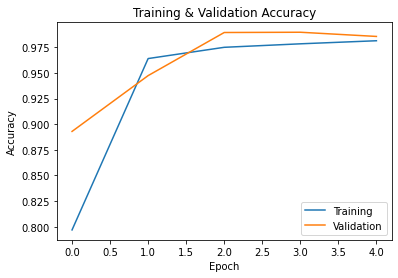

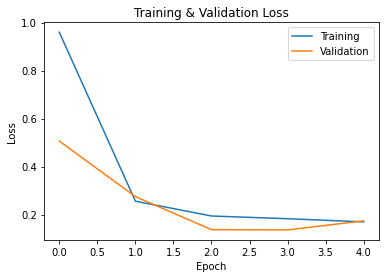

In [14]:
# Plot to see the model performance 
plt.plot(model_hist.history['accuracy'])
plt.plot(model_hist.history['val_accuracy'])
plt.legend(['Training','Validation'])
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.legend(['Training','Validation'])
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [17]:
# Evaluate on the test data
metrics = model.evaluate(x_test, y_test)
print(f'Testing Loss: {metrics[0]}')
print(f'Testing Accuracy: {metrics[1]}')

272/272 [==============================] - 1s 2ms/step - loss: 0.1725 - accuracy: 0.9868
Testing Loss: 0.17248815298080444
Testing Accuracy: 0.9867815971374512


In [18]:
model.save("CNN_Model")

INFO:tensorflow:Assets written to: CNN_Model\assets


Loading the test data Provided. 
* The test data contains images with the image name as the class, to which the image belongs to.
* we will load the data and check if the predition is correct for the image.

In [10]:
def load_test_data():
    images = []
    names = []
    size = 64,64
    for image in os.listdir(test_dir):
        temp = cv2.imread(test_dir + '/' + image)
        temp = cv2.resize(temp, size)
        images.append(temp)
        names.append(image)
    images = np.array(images)
    images = images.astype('float32')/255.0
    return images, names

test_images, test_img_names = load_test_data()

In [11]:
# make predictions on an image and append it to the list (predictions).
predictions = [model.predict_classes(image.reshape(1,64,64,3))[0] for image in test_images]

In [12]:
def get_labels_for_plot(predictions):
    predictions_labels = []
    for i in range(len(predictions)):
        for ins in labels_dict:
            if predictions[i] == labels_dict[ins]:
                predictions_labels.append(ins)
                break
    return predictions_labels

predictions_labels_plot = get_labels_for_plot(predictions)

PLOTTING THE TEST DATA ALONG WITH THE PREDICTION MADE BY THE MODEL

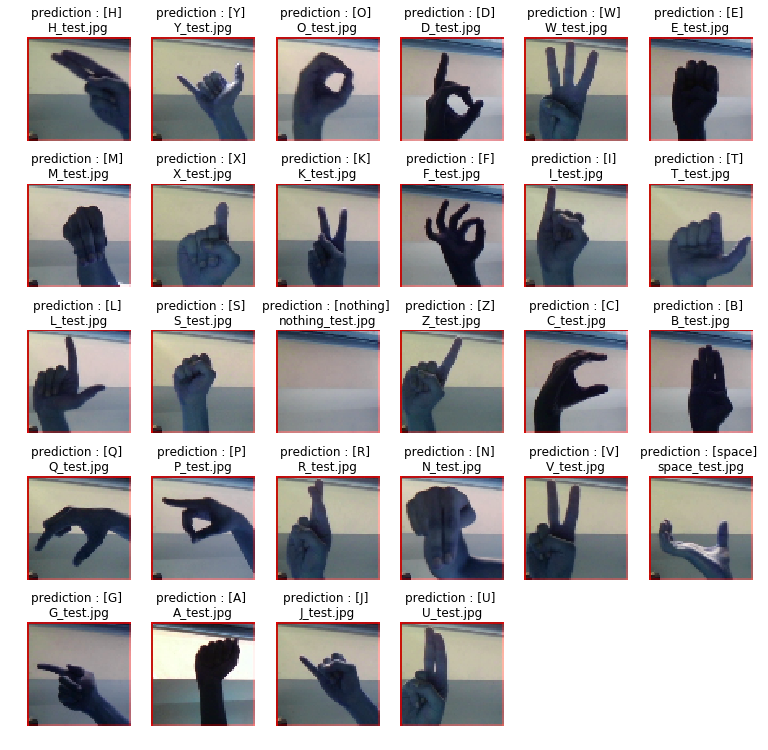

In [13]:
predfigure = plt.figure(figsize = (13,13))
def plot_image_1(fig, image, label, prediction, predictions_label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image)
    title = "prediction : [" + str(predictions_label) + "] "+ "\n" + label
    plt.title(title)
    return

image_index = 0
row = 5
col = 6
for i in range(1,(row*col-1)):
    plot_image_1(predfigure, test_images[image_index], test_img_names[image_index], predictions[image_index], predictions_labels_plot[image_index], row, col, i)
    image_index = image_index + 1
plt.show()

As we can see the predictions are correct for almost all the images. Thus the model performs well on the test set.